In [1]:
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.tree import plot_tree

from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt

import seaborn as sns


In [2]:
# Import data
df = pd.read_csv("C:\\Users\\Teemu\\Desktop\\Housing_market_analysis\\Housing-market-analysis-with-webscraped-data\\REFINED-Jul-10-2022-house-market-data.csv", index_col=0)

df.rename(columns= {'Price (€)' : 'Price'}, inplace= True)

df

,Type,Address,District,City,Price,Area (sqm.),Year built,Form of ownership,Rooms
0,Kerrostalo,Soukanlahdenkatu 9,Armonkallio,Tampere,169000.0,28.0,1963,Omistusasunto,"1h, kk, kph."
1,Kerrostalo,Lepolankatu 3 A,Kivistönmäki,Lahti,39000.0,34.0,1972,Omistusasunto,1h + kk + alk + kh + p
2,Luhtitalo,Viljatullintie 4,Järvenperä,Espoo,139000.0,28.5,2018,Omistusasunto,1h + kk
3,Kerrostalo,Maariankatu 2,Keskusta,Turku,215000.0,48.0,1962,Omistusasunto,2h + avokeittiö + kph / wc + vh
4,Omakotitalo,Puunkaatajantie 23b,Heikinlaakso,Helsinki,215000.0,90.0,1933,Omistusasunto,"4h, k, aula, vh, th, s-tilat, wc, kuisti"
...,...,...,...,...,...,...,...,...,...
45946,Kerrostalo,Luhtikatu 3 F 18,Liipola,Lahti,79500.0,53.5,1972,Omistusasunto,2h + k + vh
45947,Omakotitalo,Tikkalantie 159,Tikkala,Tohmajärvi,278000.0,225.0,1926,Omistusasunto,"4mh, wc, kylpyhuone, keittiö, sali"
45949,Erillistalo,Kirjosillankatu,Myllypohja,Lahti,268000.0,245.0,1991,Omistusasunto,"5h + k, sauna ja 2h + k parveke, + työtila j..."
45950,Rivitalo,Koparatie 3-5,Keskusta,Sodankylä,108500.0,80.0,1986,Omistusasunto,3h + k + s + v + katettu terassi


In [3]:
# There is still some whitespace left in data. like 'kerrostalo ' vs 'kerrostalo'.
df['Type']= df['Type'].str.strip()
df['City']= df['City'].str.strip()
df['Form of ownership']= df['Form of ownership'].str.strip()

# Lets create dummy variables for categorical columns
dummies = pd.get_dummies(df, columns=['Type', 'City', 'Form of ownership'])
df_dummies = df.merge(dummies)
df_dummies.drop(['Type', 'Address', 'District', 'City', 'Form of ownership', 'Rooms'], axis=1, inplace=True)

print(df_dummies.describe())


              Price   Area (sqm.)    Year built  Type_Erillistalo  \
count  4.258200e+04  42582.000000  42582.000000      42582.000000   
mean   2.176027e+05     77.599472   1993.337678          0.011202   
std    2.157849e+05     65.366593     29.852325          0.105246   
min    0.000000e+00      0.000000   1074.000000          0.000000   
25%    9.800000e+04     46.500000   1972.000000          0.000000   
50%    1.750000e+05     65.500000   1995.000000          0.000000   
75%    2.780000e+05     92.000000   2022.000000          0.000000   
max    9.300000e+06   4480.000000   2024.000000          1.000000   

       Type_Kerrostalo  Type_Luhtitalo  Type_Mökki tai huvila  \
count     42582.000000    42582.000000           42582.000000   
mean          0.617561        0.014349               0.000023   
std           0.485989        0.118925               0.004846   
min           0.000000        0.000000               0.000000   
25%           0.000000        0.000000               

# 

In [4]:
# Understanding data before modelling

df_dummies.corr().Price.sort_values(ascending=False)


Price                                   1.000000
Area (sqm.)                             0.322354
City_Helsinki                           0.310269
City_Espoo                              0.171341
Year built                              0.168790
                                          ...   
City_Lahti                             -0.052733
City_Kouvola                           -0.057385
Type_Rivitalo                          -0.064073
City_Pori                              -0.065511
Form of ownership_Asumisoikeusasunto   -0.145108
Name: Price, Length: 307, dtype: float64

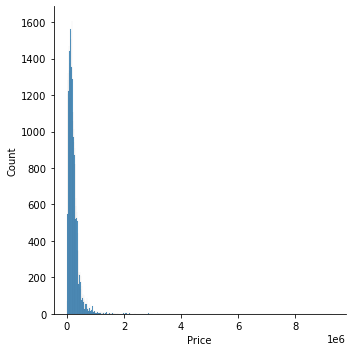

In [5]:
sns.displot(df_dummies.Price)

# Preparing the data for Pytorch

In [36]:
# Target variable:
output_col = [df_dummies.columns[0]]
output_col

['Price']

In [37]:
# Inputs
input_cols = df_dummies.columns[1::]
input_cols

Index(['Area (sqm.)', 'Year built', 'Type_Erillistalo', 'Type_Kerrostalo',
       'Type_Luhtitalo', 'Type_Mökki tai huvila', 'Type_Omakotitalo',
       'Type_Paritalo', 'Type_Puutalo-osake', 'Type_Rivitalo',
       ...
       'City_Ylitornio', 'City_Ylivieska', 'City_Ylöjärvi', 'City_Ypäjä',
       'City_Ähtäri', 'City_Äänekoski', 'Form of ownership_Asumisoikeusasunto',
       'Form of ownership_Muu', 'Form of ownership_Omistusasunto',
       'Form of ownership_Osaomistusasunto'],
      dtype='object', length=306)

In [38]:
def df_to_arrays(dataset):
    # Make a copy of the original dataset
    dataframe = dataset.copy(deep = True)

    # Extract input & outputs as numpy arrays
    inputs_array = dataframe[input_cols].to_numpy()
    targets_array = dataframe[output_col].to_numpy()
    return inputs_array, targets_array.reshape((len(dataset.index), 1))

In [39]:
inputs_array, targets_array = df_to_arrays(df_dummies)

#Normalizing data
inputs_array_norm = (inputs_array - inputs_array.mean()) / (inputs_array.max() - inputs_array.min())
targets_array_norm = (targets_array - targets_array.mean()) / (targets_array.max() - targets_array.min())


inputs_array_norm, targets_array_norm

(array([[ 0.00473715,  0.43665679, -0.00151285, ..., -0.00151285,
         -0.00128964, -0.00151285],
        [ 0.00607643,  0.43866572, -0.00151285, ..., -0.00151285,
         -0.00128964, -0.00151285],
        [ 0.00484876,  0.44893358, -0.00151285, ..., -0.00151285,
         -0.00128964, -0.00151285],
        ...,
        [ 0.05317465,  0.44290679, -0.00128964, ..., -0.00151285,
         -0.00128964, -0.00151285],
        [ 0.01634429,  0.44179072, -0.00151285, ..., -0.00151285,
         -0.00128964, -0.00151285],
        [ 0.01600947,  0.44491572, -0.00151285, ..., -0.00151285,
         -0.00128964, -0.00151285]]),
 array([[-0.00522609],
        [-0.01920459],
        [-0.0084519 ],
        ...,
        [ 0.00541907],
        [-0.01173147],
        [ 0.02918251]]))

In [40]:
val_perc = 0.2
inputs_train = inputs_array_norm[:int(len(inputs_array_norm)*(1-val_perc))]
targets_train = targets_array_norm[:int(len(targets_array_norm)*(1-val_perc))]

inputs_test = inputs_array_norm[int(len(inputs_array_norm)*(val_perc)):]
targets_test = targets_array_norm[int(len(targets_array_norm)*(val_perc)):]

inputs_train_tensor = torch.Tensor(inputs_train)
targets_train_tensor = torch.Tensor(targets_train)

print(inputs_train)
print(targets_train)
inputs_train_tensor.shape, targets_train_tensor.shape

[[ 0.00473715  0.43665679 -0.00151285 ... -0.00151285 -0.00128964
  -0.00151285]
 [ 0.00607643  0.43866572 -0.00151285 ... -0.00151285 -0.00128964
  -0.00151285]
 [ 0.00484876  0.44893358 -0.00151285 ... -0.00151285 -0.00128964
  -0.00151285]
 ...
 [ 0.00685768  0.45004965 -0.00151285 ... -0.00151285 -0.00128964
  -0.00151285]
 [ 0.01243804  0.45004965 -0.00151285 ... -0.00151285 -0.00128964
  -0.00151285]
 [ 0.01533983  0.45004965 -0.00151285 ... -0.00151285 -0.00128964
  -0.00151285]]
[[-0.00522609]
 [-0.01920459]
 [-0.0084519 ]
 ...
 [ 0.01788143]
 [ 0.04518251]
 [ 0.06310724]]


(torch.Size([34065, 306]), torch.Size([34065, 1]))

### Neural network

In [41]:
D_in = inputs_train.shape[1]
D_out = targets_train.shape[1]

print(D_in, D_out)

class Net(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
        
    def forward(self, x):
        y_pred = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(y_pred).clamp(min=0)
        y_pred = self.linear3(y_pred).clamp(min=0)
        y_pred = self.linear4(y_pred)
        return y_pred

306 1


In [74]:
H1, H2, H3 = 200, 500, 100

In [75]:
model = Net(D_in, H1, H2, H3, D_out)

# Lets move the computation to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inputs_train_tensor = inputs_train_tensor.to(device)
targets_train_tensor = targets_train_tensor.to(device)
model.to(device)


Net(
  (linear1): Linear(in_features=306, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=500, bias=True)
  (linear3): Linear(in_features=500, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=1, bias=True)
)

In [76]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [77]:
criterion = nn.MSELoss(reduction='sum')

In [78]:
losses = []

for t in range(3000):
    y_pred = model(inputs_train_tensor)
    
    loss = criterion(y_pred, targets_train_tensor)
    print(t, loss.item())
    losses.append(loss.item())
    
    if torch.isnan(loss):
        break
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 177.0670166015625
1 157.48724365234375
2 139.16705322265625
3 122.34197235107422
4 107.11224365234375
5 93.48676300048828
6 81.19810485839844
7 70.10602569580078
8 60.25888442993164
9 51.892120361328125
10 44.917572021484375
11 39.2028694152832
12 34.600154876708984
13 30.687639236450195
14 27.430465698242188
15 24.806255340576172
16 22.785137176513672
17 21.267379760742188
18 20.202999114990234
19 19.563968658447266
20 19.24114990234375
21 19.134204864501953
22 19.195486068725586
23 19.38094711303711
24 19.648639678955078
25 19.959692001342773
26 20.27371597290039
27 20.56219482421875
28 20.810123443603516
29 21.003559112548828
30 21.13436508178711
31 21.199254989624023
32 21.19881248474121
33 21.136882781982422
34 21.02228546142578
35 20.86565399169922
36 20.678363800048828
37 20.472396850585938
38 20.258800506591797
39 20.047409057617188
40 19.846637725830078
41 19.663265228271484
42 19.502307891845703
43 19.366867065429688
44 19.25894546508789
45 19.17880630493164
46 19.124904632

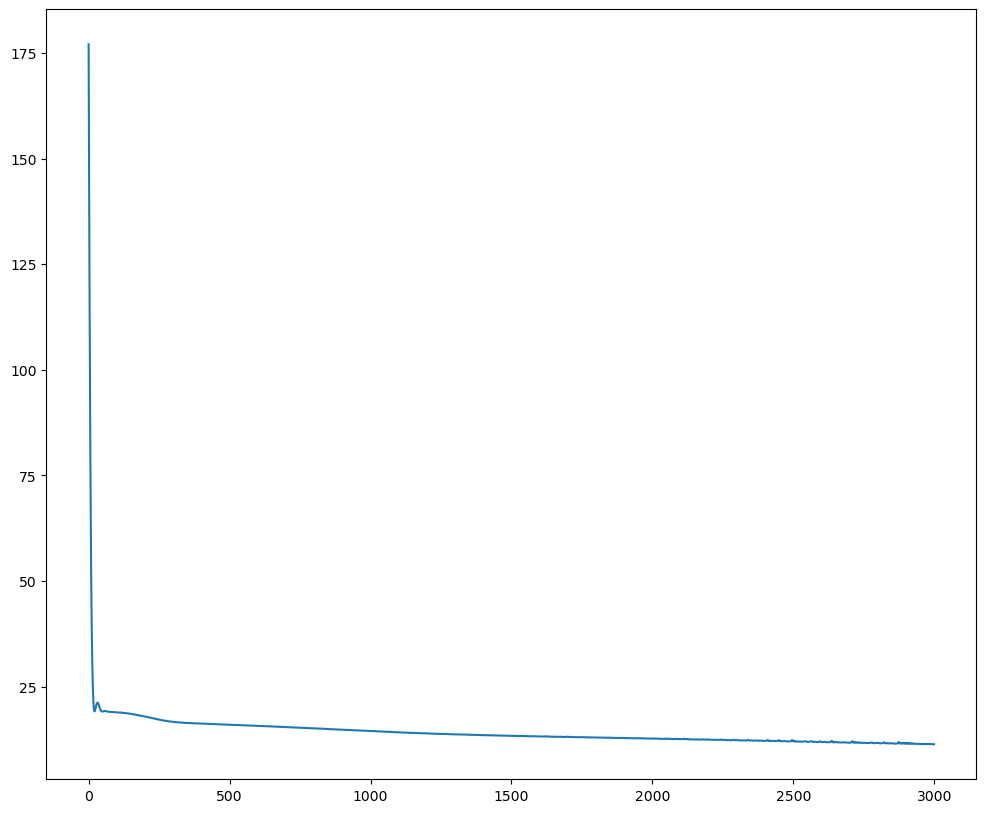

In [79]:
plt.figure(figsize=(12, 10))
plt.plot(range(len(losses)), losses)
plt.show()

In [80]:
inputs_test_tensor = torch.Tensor(inputs_test)
inputs_test_tensor = inputs_test_tensor.to(device)

test_y = model(inputs_test_tensor)

In [81]:
# Send result back to CPU from GPU
test_y = test_y.to("cpu")

# Transform data from tensor to array
test_y = test_y.data.numpy()

print(test_y)


[[ 0.02524455]
 [-0.00769073]
 [-0.00940483]
 ...
 [ 0.0402004 ]
 [-0.00891998]
 [ 0.00226542]]


In [82]:
# De-normalize test_y and targets_test so we see actual prices and not normalized values
predictions = test_y*(targets_array.max() - targets_array.min()) + targets_array.mean()
actual_prices = targets_test*(targets_array.max() - targets_array.min()) + targets_array.mean()

In [83]:
# Now lets create a dataframe where we can compare the predicted values to the actual ones.
predictions_list = []
actual_prices_list = []

for i in predictions:
    predictions_list.append(float(i[0]))

for i in actual_prices:
    actual_prices_list.append(float(i[0]))

df = pd.DataFrame({'Predicted price':predictions_list,'Actual price':actual_prices_list})

df

,Predicted price,Actual price
0,452376.937500,685000.0
1,146078.906250,289000.0
2,130137.750000,44000.0
3,352162.343750,454000.0
4,184540.125000,99900.0
...,...,...
34061,105354.929688,79500.0
34062,416125.937500,278000.0
34063,591466.437500,268000.0
34064,134646.890625,108500.0
